In [1]:
import IPython.display
import librosa
import librosa.display
import pandas as pd
import os
import struct
import glob
import soundfile as sf
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint 
from datetime import datetime
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
# Se obtienen las diferentes rutas de los datos, tanto audios como metadata y path para obtener las muestras
file_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/UrbanSounds8k/UrbanSound8K/audio'
urbansound8k = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/UrbanSounds8k/UrbanSound8K/metadata/UrbanSound8K.csv')
file_viz = glob.glob('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/UrbanSounds8k/UrbanSound8K/audio/fold1/*')

In [3]:
#pd.set_option('display.max_rows', None)
urbansound8k.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [4]:
#Se cambia el dataset para unicamente tomar las clases de interés para el trabajo
urbansound8k = urbansound8k.loc[((urbansound8k["class"]=="gun_shot") | (urbansound8k["class"]=="siren"))]
urbansound8k.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
106,102305-6-0-0.wav,102305,0.0,2.61161,1,1,6,gun_shot
114,102853-8-0-0.wav,102853,0.0,4.00000,2,7,8,siren
115,102853-8-0-1.wav,102853,0.5,4.50000,2,7,8,siren
116,102853-8-0-2.wav,102853,1.0,5.00000,2,7,8,siren
117,102853-8-0-3.wav,102853,1.5,5.50000,2,7,8,siren


In [5]:
class_map = {'0' : 'air_conditioner', '1' : 'car_horn', '2' : 'children_playing', '3' : 'dog_bark', '4' : 'drilling', 
                 '5' : 'engine_idling', '6' : 'gun_shot', '7' : 'jackhammer', '8' : 'siren', '9' : 'street_music'}
#Se crea el mapa de las clases a utilizar
class_map = {'6' : 'gun_shot', '8' : 'siren',}
pd.DataFrame(sorted(list(class_map.items())))

,0,1
0,6,gun_shot
1,8,siren


In [6]:
#Se toman muestras del dataset para ser previsualizadas
samples = [(class_map[label], [f for f in file_viz if f.split('-')[1] == label][0]) 
           for label in class_map.keys()]

In [7]:
#Funcion para obtener los datos del sonido muestreados a una tasa de 22050 por defecto.
def get_sound_data(path, sr=22050):
    data, fsr = sf.read(path)
    data_22k = librosa.resample(data.T, fsr, sr)
    if len(data_22k.shape) > 1:
        data_22k = np.average(data_22k, axis=0)
    return data_22k, sr
sample_data = [(sample[0], get_sound_data(sample[1])) for sample in samples]
[(sample[0], sample[1][0].shape) for sample in sample_data]

[('gun_shot', (57551,)), ('siren', (88200,))]

In [8]:
#Se despliegan las muestras de los datos para ser reproducidas.
for data in sample_data:
    print(data[0], ':')
    IPython.display.display(IPython.display.Audio(data=data[1][0], rate=data[1][1]))

gun_shot :


siren :


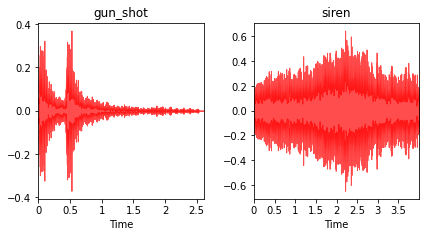

In [9]:
#Se despliega la forma de onda para las muestras tomadas
i = 1
fig = plt.figure(figsize=(15, 6))
for item in sample_data:
    plt.subplot(2, 5, i)
    librosa.display.waveplot(item[1][0], sr=item[1][1], color='r', alpha=0.7)
    plt.title(item[0])
    i += 1
plt.tight_layout()

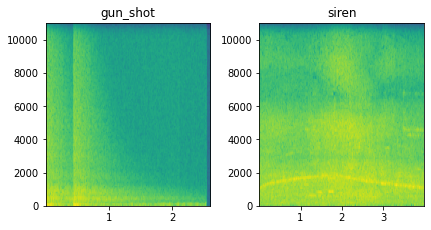

In [10]:
#Se muestran los espectogramas correspondeintes a las muestras tomadas.
i = 1
fig = plt.figure(figsize=(15, 6))
for item in sample_data:
    plt.subplot(2, 5, i)
    specgram(item[1][0], Fs=item[1][1])
    plt.title(item[0])
    i += 1
plt.tight_layout()

Extracting features using Librosa

In [11]:
#Se define funcion para extrar las caracteristicas con la librería librosa, obetiendo los coeficientes ceptrales de frecuencia de Mel
#Se realiza un pading en el tamaño para que concuerden los tamaños de las caracteristicas de entrada al modelo.
max_pad_len = 174
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [12]:
features = []

# Iterate through each sound file and extract the features 
for index, row in urbansound8k.iterrows():
    
    file_name = os.path.join(os.path.abspath(file_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    
    class_label = row["classID"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

In [13]:
featuresdf.head()

,feature,class_label
0,"[[-119.95263, -98.58099, -102.46894, -113.9573...",6
1,"[[-212.37451, -203.63791, -200.84283, -208.838...",8
2,"[[-196.08969, -200.47655, -211.0078, -213.0787...",8
3,"[[-187.98851, -198.36465, -217.52213, -221.166...",8
4,"[[-224.6572, -225.77936, -235.45703, -238.4739...",8


In [14]:
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 3)

In [16]:
num_rows = 40
num_columns = 174
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)
print(x_train.shape)

num_labels = yy.shape[1]
filter_size = 3

(1042, 40, 174, 1)


#Creating the Model

In [17]:
# Constructing model with RELu and SoftMax activation functions:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(num_labels, activation='softmax'))

In [18]:
#Se compila el modelo con la función de perdida de crosentrpía categorica 
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [19]:
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 39, 173, 16)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 86, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 19, 86, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 85, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 42, 32)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 9, 42, 32)         0

In [20]:
#Entrenamiento del modelo 
num_epochs = 40
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data = (x_test, y_test), callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/40
5/5 [==============================] - ETA: 0s - loss: 4.1440 - accuracy: 0.5864
Epoch 1: val_loss improved from inf to 2.15532, saving model to saved_models/weights.best.basic_cnn.hdf5
5/5 [==============================] - 7s 917ms/step - loss: 4.1440 - accuracy: 0.5864 - val_loss: 2.1553 - val_accuracy: 0.7126
Epoch 2/40
5/5 [==============================] - ETA: 0s - loss: 4.3833 - accuracy: 0.7131
Epoch 2: val_loss improved from 2.15532 to 1.64019, saving model to saved_models/weights.best.basic_cnn.hdf5
5/5 [==============================] - 5s 907ms/step - loss: 4.3833 - accuracy: 0.7131 - val_loss: 1.6402 - val_accuracy: 0.7126
Epoch 3/40
5/5 [==============================] - ETA: 0s - loss: 2.7433 - accuracy: 0.7150
Epoch 3: val_loss improved from 1.64019 to 0.44465, saving model to saved_models/weights.best.basic_cnn.hdf5
5/5 [==============================] - 5s 904ms/step - loss: 2.7433 - accuracy: 0.7150 - val_loss: 0.4447 - val_accuracy: 0.7280
Epoch 4/40
5/5

In [21]:
# Evaluating the model on the training and testing set

score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9856045842170715
Testing Accuracy:  0.9961685538291931


#Evaluation Metrics

In [22]:
y_true = np.argmax(y_test,axis=1)
y_pred = np.argmax(model.predict(x_test),axis=1)
print('\nConfusion Matrix :\n\n')
print(confusion_matrix(y_true,y_pred))
print('\n\nClassification Report : \n\n',classification_report(y_true,y_pred))


Confusion Matrix :


[[ 75   0]
 [  1 185]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.99      1.00      0.99        75
           1       1.00      0.99      1.00       186

    accuracy                           1.00       261
   macro avg       0.99      1.00      1.00       261
weighted avg       1.00      1.00      1.00       261



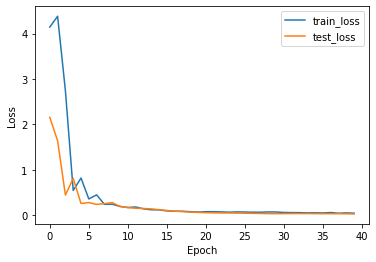

In [23]:
# Plotting Loss of Model

metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['train_loss', 'test_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

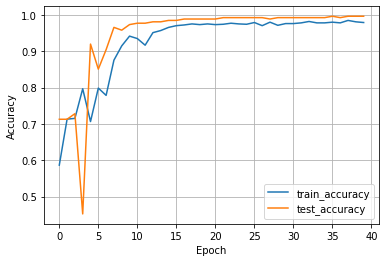

In [24]:
# Plotting Accuracy of Model

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

#Save the entire model as a SavedModel.

In [25]:
#!mkdir -p saved_model

model.save('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/UrbanSounds8k/my_second_CNN2D_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/UrbanSounds8k/my_second_CNN2D_model/assets


#Reload a fresh Keras model from the saved model

In [26]:
import IPython.display
import librosa
import librosa.display
import pandas as pd
import os
import struct
import glob
import soundfile as sf
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint 
from datetime import datetime
from sklearn import metrics 
import librosa as lb
import IPython.display as ipd
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [43]:
def predict(path):
    num_rows = 40
    num_columns = 174
    num_channels = 1
    audio = extract_features(path)
    audioP = audio.reshape(1, num_rows, num_columns, num_channels)
    probOut = model.predict(audioP)[0]
    indexMax = np.argmax(probOut)
    print(probOut)
    print(indexMax)
    maxProb = probOut[indexMax]
    if(maxProb>0.99):
      if(indexMax==0):
        classP = 'gun_shot'
      else:
        classP = 'siren'
    else:
      classP = 'None'
    print('Class predicted :',classP,'\n\n')
    return ipd.Audio(path)

In [44]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/UrbanSounds8k/my_second_CNN2D_model')

# Check its architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 39, 173, 16)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 86, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 19, 86, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 85, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 42, 32)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 9, 42, 32)         0

In [45]:
predict('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/UrbanSounds8k/UrbanSound8K/audio/fold7/102853-8-0-1.wav')


[6.5963442e-04 9.9934036e-01]
1
Class predicted : siren 




In [46]:
predict('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/UrbanSounds8k/UrbanSound8K/audio/fold1/102305-6-0-0.wav')

[0.9975314  0.00246853]
0
Class predicted : gun_shot 




#To record and save audio directly on colab

In [47]:
#Se implementan funciones para grabar y guardar audio directamente desde el colab
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1200))
  b = b64decode(s.split(',')[1])
  audio = AudioSegment.from_file(BytesIO(b))
  return audio

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def recordAndSave(sec=3, path="audio.wav"):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1200))
  b = b64decode(s.split(',')[1])
  with open(path,'wb') as f:
    f.write(b)
  return path  # or webm ?

In [48]:
#Grabar porción de audio directamente desde el colab
pathaudio2 = recordAndSave(sec=3,path='/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/sonidosPrueba/prueba1.wav')

<IPython.core.display.Javascript object>

In [49]:
#Se predice el audio que fue grabado anteriormente
predict(pathaudio2)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[0.01091129 0.9890887 ]
1
Class predicted : None 




In [51]:
#Grabar porción de audio directamente desde el colab
pathaudio3 = recordAndSave(sec=3,path='/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/sonidosPrueba/prueba2.wav')

<IPython.core.display.Javascript object>

In [52]:
#Se predice el audio que fue grabado anteriormente
predict(pathaudio3)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[5.8423918e-08 1.0000000e+00]
1
Class predicted : siren 


